In [8]:
# display some images for every different expression

import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# size of the image: 48*48 pixels
pic_size = 64
    
# input path for the images
base_path = "input/images/images//kaggle/input/face-expression-recognition-dataset/"

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train/"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'input/images/images//kaggle/input/face-expression-recognition-dataset/train/'

<Figure size 864x1440 with 0 Axes>

In [2]:
# count number of train images for each expression

for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

3205 surprise images
4103 fear images
3993 angry images
4982 neutral images
4938 sad images
436 disgust images
7164 happy images


In [3]:
from keras.preprocessing.image import ImageDataGenerator

# number of images to feed into the NN for every batch
batch_size = 128

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

train_generator = datagen_train.flow_from_directory(base_path + "train",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(base_path + "validation",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [4]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [4]:
%%time

# number of epochs to train the NN
epochs = 50

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

Using TensorFlow backend.


NameError: name 'model' is not defined

In [6]:
# serialize model structure to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

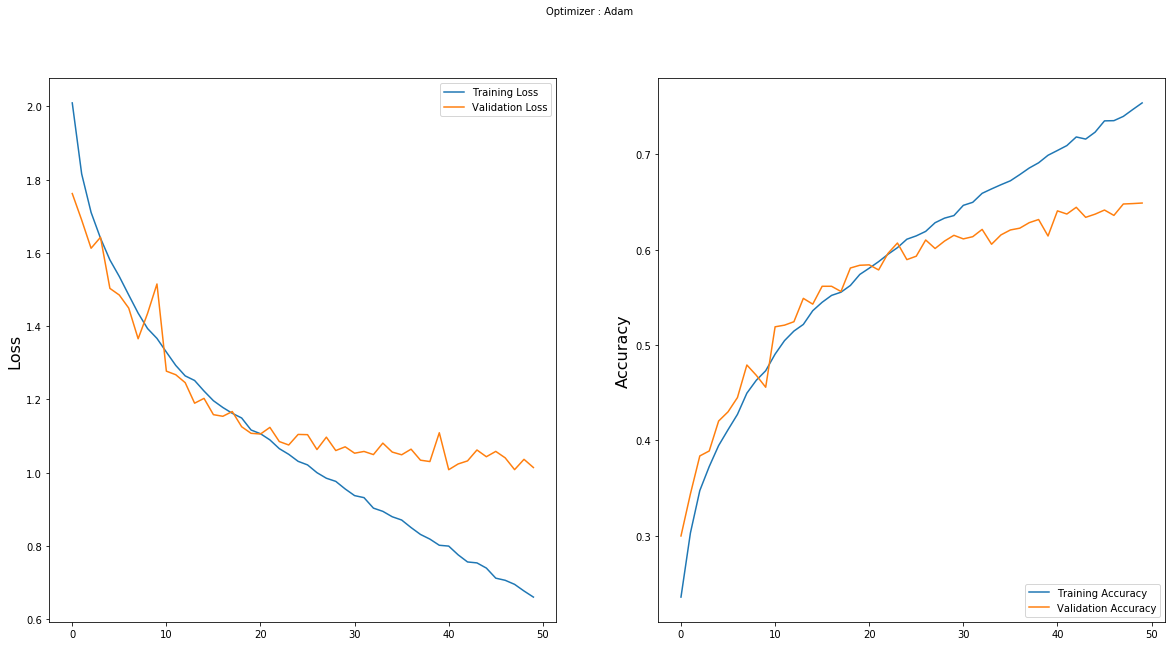

In [7]:
# plot the evolution of Loss and Acuracy on the train and validation sets

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

<Figure size 432x288 with 0 Axes>

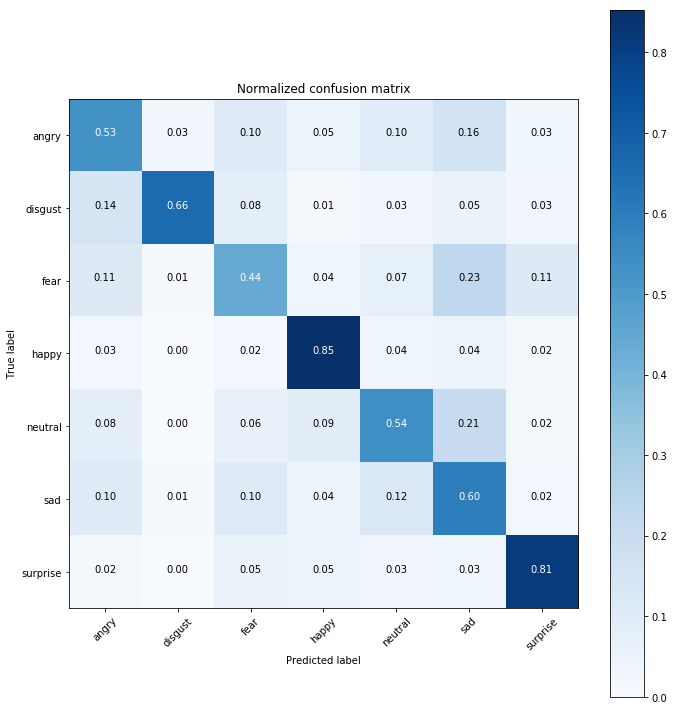

In [8]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

In [3]:
# Save the trained model to HDF5 format
model.save("emotion_model")
print("Model saved as emotion_model.h5")


NameError: name 'model' is not defined

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 64)        640       
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 24, 24, 128)       512       
__________

In [2]:
import os
import csv
from collections import Counter, deque
import cv2
import numpy as np
from tensorflow.keras.models import load_model

# ---------------------------
# USER CONFIG — edit these
# ---------------------------
MODEL_PATH = "/kaggle/working/emotion_model.h5"     # path to your saved model
VIDEO_PATH = "/kaggle/input/demo-video/demo .mp4"            # path to the input video
OUTPUT_PATH = "annotated_output.mp4"  # set to None to disable saving annotated video
CSV_OUTPUT = None                   # set to None to auto-generate <video_basename>_emotion_summary.csv
DISPLAY_FRAMES = False              # set True to show processing window (press 'q' to quit)
SKIP_FRAMES = 0                     # process every (SKIP_FRAMES+1)th frame (0 = process every frame)
SMOOTHING_WINDOW = 5                # majority smoothing window
MIN_FACE_SIZE = (30, 30)            # min face size for Haar detector
FACE_CASCADE_PATH = None            # None -> use OpenCV default
# ---------------------------

# default labels (update if your model uses a different ordering)
DEFAULT_LABELS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# ---------------------------
# Helper functions
# ---------------------------

def get_model_io_info(model):
    """Return (target_size (w,h), channels) inferred from model.input_shape."""
    input_shape = model.input_shape
    if isinstance(input_shape, list):
        input_shape = input_shape[0]
    if len(input_shape) == 4:
        _, h, w, c = input_shape
    else:
        raise ValueError(f"Unsupported model input shape: {input_shape}")
    if h is None or w is None:
        h, w = 48, 48
    if c is None:
        c = 1
    return (w, h), int(c)

def preprocess_face(face_img, target_size, channels):
    """Resize, convert channels, scale to [0,1], add batch dimension."""
    w, h = target_size
    face = cv2.resize(face_img, (w, h), interpolation=cv2.INTER_AREA)
    if channels == 1:
        face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        face = np.expand_dims(face, axis=-1)
    else:
        face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = face.astype("float32") / 255.0
    face = np.expand_dims(face, axis=0)  # (1, h, w, c)
    return face

# ---------------------------
# Core processing
# ---------------------------

def process_video(model_path, video_path, output_path=None,
                  csv_out=None, display=False, skip_frames=0,
                  face_cascade_path=None, labels=None, smoothing_window=5,
                  min_face_size=(30,30)):
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model not found: {model_path}")
    if not os.path.exists(video_path):
        raise FileNotFoundError(f"Video not found: {video_path}")

    print(f"[INFO] Loading model from: {model_path}")
    model = load_model(model_path)
    print("[INFO] Model loaded.")

    try:
        target_size, channels = get_model_io_info(model)
        print(f"[INFO] Model expects input size={target_size}, channels={channels}")
    except Exception as e:
        print("[WARN] Could not determine model input shape automatically:", e)
        print("[INFO] Falling back to 48x48 grayscale.")
        target_size, channels = (48,48), 1

    if labels is None:
        labels = DEFAULT_LABELS
    n_classes = len(labels)

    if face_cascade_path is None:
        face_cascade_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    if not os.path.exists(face_cascade_path):
        raise FileNotFoundError(f"Haar cascade not found: {face_cascade_path}")
    face_cascade = cv2.CascadeClassifier(face_cascade_path)
    print(f"[INFO] Using face cascade: {face_cascade_path}")

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise IOError(f"Cannot open video: {video_path}")
    fps = cap.get(cv2.CAP_PROP_FPS) if cap.get(cv2.CAP_PROP_FPS) > 0 else 25
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"[INFO] Video: {width}x{height} @ {fps}fps, {total_frames} frames")

    writer = None
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        print(f"[INFO] Annotated video will be saved to: {output_path}")

    if csv_out is None:
        csv_out = os.path.splitext(os.path.basename(video_path))[0] + "_emotion_summary.csv"

    frame_results = []
    video_counts = Counter()
    smooth_queue = deque(maxlen=smoothing_window)

    frame_idx = -1
    print("[INFO] Starting frame processing...")
    while True:
        grabbed, frame = cap.read()
        if not grabbed:
            break
        frame_idx += 1

        if skip_frames > 0 and (frame_idx % (skip_frames + 1) != 0):
            continue

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=min_face_size)

        if len(faces) == 0:
            frame_results.append({
                'frame': frame_idx,
                'timestamp_sec': frame_idx / fps,
                'found_face': False,
                'predicted_label': None,
                'confidence': None
            })
            cv2.putText(frame, "No face detected", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2)
        else:
            frame_preds = []
            for (x, y, w, h) in faces:
                pad = int(0.15 * (w+h) / 2)
                x1 = max(0, x-pad); y1 = max(0, y-pad)
                x2 = min(frame.shape[1], x + w + pad); y2 = min(frame.shape[0], y + h + pad)
                face_img = frame[y1:y2, x1:x2]
                if face_img.size == 0:
                    continue
                inp = preprocess_face(face_img, target_size, channels)
                preds = model.predict(inp, verbose=0)[0]
                # align preds length with labels
                if preds.shape[0] != n_classes:
                    if preds.shape[0] > n_classes:
                        preds = preds[:n_classes]
                    else:
                        preds = np.concatenate([preds, np.zeros(n_classes - preds.shape[0])])
                top_idx = int(np.argmax(preds))
                label = labels[top_idx]
                conf = float(preds[top_idx])
                frame_preds.append({'bbox': (x1,y1,x2,y2), 'label': label, 'conf': conf})

            if len(frame_preds) == 0:
                frame_results.append({
                    'frame': frame_idx,
                    'timestamp_sec': frame_idx / fps,
                    'found_face': False,
                    'predicted_label': None,
                    'confidence': None
                })
            else:
                best = max(frame_preds, key=lambda p: p['conf'])
                predicted_label = best['label']
                confidence = best['conf']
                smooth_queue.append(predicted_label)
                majority = Counter(smooth_queue).most_common(1)[0][0] if len(smooth_queue) > 0 else predicted_label

                frame_results.append({
                    'frame': frame_idx,
                    'timestamp_sec': frame_idx / fps,
                    'found_face': True,
                    'predicted_label': predicted_label,
                    'confidence': confidence
                })
                video_counts[predicted_label] += 1

                # Overlay each face
                for p in frame_preds:
                    x1,y1,x2,y2 = p['bbox']
                    lab = p['label']; conf = p['conf']
                    if lab.lower() == 'happy':
                        color = (36,255,12)
                    elif lab.lower() in ('angry','sad','disgust','fear'):
                        color = (0,0,255)
                    else:
                        color = (255,255,255)
                    cv2.rectangle(frame, (x1,y1), (x2,y2), color, 2)
                    text = f"{lab} ({conf*100:.0f}%)"
                    y_text = y1 - 10 if y1 - 10 > 10 else y1 + 20
                    cv2.putText(frame, text, (x1, y_text), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

                cv2.putText(frame, f"Smoothed: {majority}", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,255), 2)

        if writer is not None:
            writer.write(frame)
        if display:
            cv2.imshow("Emotion Detection", frame)
            key = cv2.waitKey(1) & 0xFF
            if key == ord('q'):
                print("[INFO] Early exit requested.")
                break

    cap.release()
    if writer is not None:
        writer.release()
    if display:
        cv2.destroyAllWindows()

    total_detected = sum(1 for r in frame_results if r['found_face'])
    print("[INFO] Processing completed.")
    print(f"[INFO] Sampled frames: {len(frame_results)}, Frames with face: {total_detected}")
    print("[INFO] Emotion counts (frame-level):")
    for lab, cnt in video_counts.items():
        print(f"  {lab}: {cnt}")
    if video_counts:
        top = video_counts.most_common(1)[0]
        print(f"[INFO] Most frequent: {top[0]} ({top[1]} frames)")

    # write CSV
    print(f"[INFO] Writing CSV summary to: {csv_out}")
    with open(csv_out, mode='w', newline='', encoding='utf-8') as f:
        w = csv.writer(f)
        w.writerow(['frame','timestamp_sec','found_face','predicted_label','confidence'])
        for r in frame_results:
            w.writerow([r['frame'], f"{r['timestamp_sec']:.3f}", r['found_face'], r['predicted_label'], r['confidence']])

    return {
        'frames_processed': len(frame_results),
        'frames_with_face': total_detected,
        'counts': dict(video_counts),
        'csv': os.path.abspath(csv_out),
        'annotated_video': os.path.abspath(output_path) if output_path else None
    }

# ---------------------------
# Run (edit variables above and then run this file)
# ---------------------------

if __name__ == "__main__":
    summary = process_video(
        model_path=MODEL_PATH,
        video_path=VIDEO_PATH,
        output_path=OUTPUT_PATH,
        csv_out=CSV_OUTPUT,
        display=DISPLAY_FRAMES,
        skip_frames=SKIP_FRAMES,
        face_cascade_path=FACE_CASCADE_PATH,
        labels=None,
        smoothing_window=SMOOTHING_WINDOW,
        min_face_size=tuple(MIN_FACE_SIZE)
    )
    print("[INFO] Summary:", summary)


FileNotFoundError: Model not found: /kaggle/working/emotion_model.h5